# Kaggle Configurations

Dataset: CIHP-CelebMaskHQ-6class-256


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
remainaplomb_cihp_celebmaskhq_6class_256_path = kagglehub.dataset_download('remainaplomb/cihp-celebmaskhq-6class-256')

print('Data source import complete.')


100%|██████████| 2.19G/2.19G [01:41<00:00, 23.2MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [ ]:
import os
import random
import datetime
import zipfile

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter(log_dir="runs/my_experiment")

# Data

In [ ]:
data=remainaplomb_cihp_celebmaskhq_6class_256_path
print(data)

/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1


In [ ]:
images_path="/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/original"
masks_path="/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/mask"
print(images_path)
print(masks_path)

/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/original
/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/mask


Sample Images


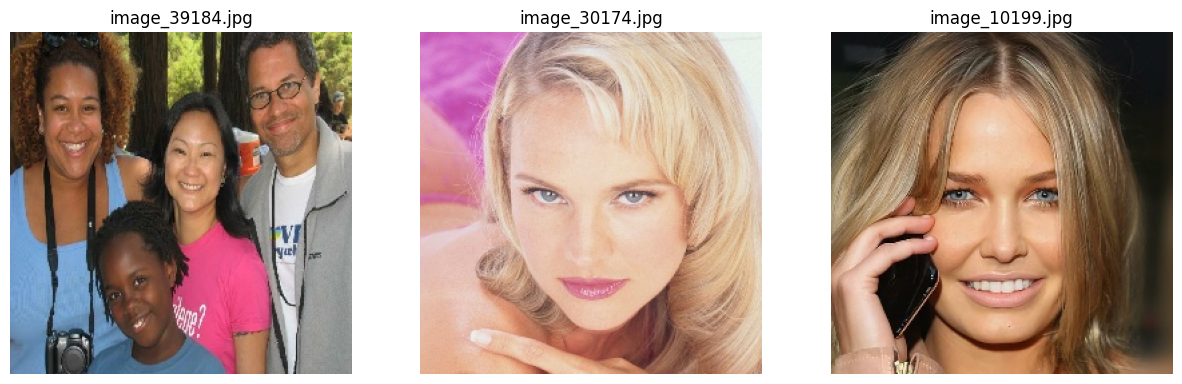

Sample Masks


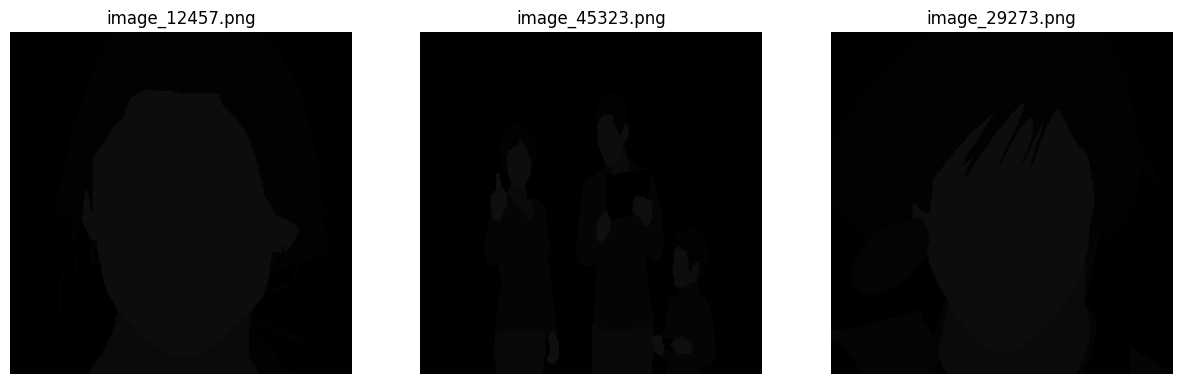

In [ ]:
def load_and_plot_images(images_path, num_images=3):
    images_list = os.listdir(images_path)
    sample_images = random.sample(images_list, num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(images_path, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(img_file))
    plt.show()
print("Sample Images")
load_and_plot_images(images_path)
print("Sample Masks")
load_and_plot_images(masks_path)

In [ ]:
images_number=len(os.listdir(images_path))
print(images_number)
masks_number=len(os.listdir(masks_path))
print(masks_number)

63280
63280


In [ ]:
image_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))
split_index = int(0.8 * len(image_filenames))
train_images_filenames = image_filenames[:split_index]
train_masks_filenames = mask_filenames[:split_index]
test_images_filenames = image_filenames[split_index:]
test_masks_filenames = mask_filenames[split_index:]
print(len(train_images_filenames))
print(len(train_masks_filenames))
print(len(test_images_filenames))
print(len(test_masks_filenames))

50624
50624
12656
12656


In [ ]:
for img, mask in zip(train_images_filenames[:5], train_masks_filenames[:5]):
    print(f"Image: {img}, Mask: {mask}")


Image: image_0.jpg, Mask: image_0.png
Image: image_1.jpg, Mask: image_1.png
Image: image_10.jpg, Mask: image_10.png
Image: image_100.jpg, Mask: image_100.png
Image: image_1000.jpg, Mask: image_1000.png


In [ ]:
train_images_path = [os.path.join(images_path, fname) for fname in train_images_filenames]
train_masks_path = [os.path.join(masks_path, fname) for fname in train_masks_filenames]
test_images_path = [os.path.join(images_path, fname) for fname in test_images_filenames]
test_masks_path = [os.path.join(masks_path, fname) for fname in test_masks_filenames]

In [ ]:
print(train_images_path[0])
print(train_masks_path[0])
print(test_images_path[0])
print(test_masks_path[0])

/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/original/image_0.jpg
/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/mask/image_0.png
/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/original/image_5556.jpg
/root/.cache/kagglehub/datasets/remainaplomb/cihp-celebmaskhq-6class-256/versions/1/mask/image_5556.png


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_paths, masks_paths, image_size=256, transform=None):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.image_size = image_size
        self.transform = transform


        self.image_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.long())
        ])

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):

        image_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [ ]:
train_dataset = CustomDataset(train_images_path,train_masks_path)
test_dataset = CustomDataset(test_images_path,test_masks_path)
train_loader = DataLoader(train_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    break

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


# Model

In [ ]:
class double_convolution(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(double_convolution,self).__init__()
    self.convolution=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.convolution(x)

class downsampling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(downsampling, self).__init__()
    self.doubleconv=double_convolution(in_channels, out_channels)
    self.maxpool=nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self,x):
    conv=self.doubleconv(x)
    pool=self.maxpool(conv)
    return conv, pool

class upsampling(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(upsampling,self).__init__()
    self.upsample=nn.ConvTranspose2d(in_channels,in_channels//2,kernel_size=2,stride=2)
    self.conv=double_convolution(in_channels,out_channels)
  def forward(self,x1,x2):
    x1=self.upsample(x1)

    x=torch.cat([x1,x2],1)

    return self.conv(x)



In [ ]:
class unet(nn.Module):
    def __init__(self, in_channels, classes, down_list):
        super().__init__()
        self.down1 = downsampling(in_channels, down_list[0])
        self.down2 = downsampling(down_list[0], down_list[1])
        self.down3 = downsampling(down_list[1], down_list[2])
        self.down4 = downsampling(down_list[2], down_list[3])

        self.bottleneck = double_convolution(down_list[3], down_list[4])

        self.up1 = upsampling(down_list[4], down_list[3])
        self.up2 = upsampling(down_list[3], down_list[2])
        self.up3 = upsampling(down_list[2], down_list[1])
        self.up4 = upsampling(down_list[1], down_list[0])


        self.final_layer = nn.Conv2d(down_list[0], classes, kernel_size=1)

    def forward(self, x):
        convolution_result1, pooling_result1 = self.down1(x)
        convolution_result2, pooling_result2 = self.down2(pooling_result1)
        convolution_result3, pooling_result3 = self.down3(pooling_result2)
        convolution_result4, pooling_result4 = self.down4(pooling_result3)

        bottleneck_result = self.bottleneck(pooling_result4)

        up_result1 = self.up1(bottleneck_result, convolution_result4)
        up_result2 = self.up2(up_result1, convolution_result3)
        up_result3 = self.up3(up_result2, convolution_result2)
        up_result4 = self.up4(up_result3, convolution_result1)

        return self.final_layer(up_result4)


In [ ]:
down_list = [64, 128, 256, 512, 1024]
input_tensor = torch.randn(1, 3, 256, 256)
model = unet(in_channels=3, classes=6,down_list=down_list)

output_tensor = model(input_tensor)
print(f"Output shape: {output_tensor.shape}")

Output shape: torch.Size([1, 6, 256, 256])


In [ ]:
for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    break

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

unet(
  (down1): downsampling(
    (doubleconv): double_convolution(
      (convolution): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): downsampling(
    (doubleconv): double_convolution(
      (convolution): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): downsampling(
    (doubleconv): double_convolution(
      (convolution): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3

The model outputs a tensor of shape (batch_size, 6, 256, 256), where each channel represents the probability map for a specific class.

The ground truth masks are of shape (batch_size, 1, 256, 256), where each pixel value represents the class label.

**nn.CrossEntropyLoss()** expects the input to be a tensor of shape (batch_size, num_classes, height, width) and the target to be a tensor of shape (batch_size, height, width) with integer class labels.

**masks.squeeze(1).long()** converts the mask tensor to the required shape and data type.

# Loss funnctions

Dice Cofficient = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)

Dice Loss = 1-Dice Cofficient

IOU = |A∩B| / |A∪B| = TP / (TP + FP + FN)

IOU Loss = 1 - IOU

Note:

By **dim=(1, 2)** we sum over the height and width dimensions of each image,  treating each image as an independent unit.

In [ ]:
def iou_loss(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    intersection = (outputs == masks.squeeze(1)).float().sum(dim=(1, 2))
    union = (outputs | masks.squeeze(1)).float().sum(dim=(1, 2))
    iou = intersection / (union + 1e-16)
    return 1-iou.mean()

In [ ]:
def dice_loss(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    intersection = (outputs * masks.squeeze(1)).sum(dim=(1, 2))
    union = (outputs + masks.squeeze(1)).sum(dim=(1, 2))
    dice = (2.0 * intersection + 1e-8) / (union + 1e-8)
    return 1 - dice.mean()

# Training and Testing

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    dice = 0.0
    iou = 0.0
    running_dice_loss = 0.0
    running_iou_loss = 0.0

    for i, (images, masks) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        masks_one_hot = F.one_hot(masks.squeeze(1).long(), num_classes=6)
        loss = criterion(outputs, masks_one_hot)


        dice += dice_loss(outputs, masks)
        iou += iou_loss(outputs, masks)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_dice_loss += dice * images.size(0)
        running_iou_loss += iou * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_dice_loss = running_dice_loss / len(train_loader.dataset)
    epoch_iou_loss = running_iou_loss / len(train_loader.dataset)
    return epoch_loss, epoch_dice_loss, epoch_iou_loss

In [ ]:
def evaluate(model, test_loader, device):
    model.eval()
    with torch.no_grad():
      running_loss = 0.0
      dice = 0.0
      iou = 0.0
      running_dice_loss = 0.0
      running_iou_loss = 0.0

    for i, (images, masks) in enumerate(tqdm(test_loader)):

        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)

        masks_one_hot = F.one_hot(masks.squeeze(1).long(), num_classes=6)
        loss = criterion(outputs, masks_one_hot)

        dice += dice_loss(outputs, masks)
        iou += iou_loss(outputs, masks)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_dice_loss += dice * images.size(0)
        running_iou_loss += iou * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_dice_loss = running_dice_loss / len(train_loader.dataset)
    epoch_iou_loss = running_iou_loss / len(train_loader.dataset)
    return epoch_loss, epoch_dice_loss, epoch_iou_loss

In [ ]:
best_test_loss = float('inf')
best_model_path = "best_model.pth"

for epoch in range(10):
    print(f"Epoch {epoch+1}:")
    train_loss, train_dice_loss, train_iou_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, test_dice_loss, test_iou_loss = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Dice Loss = {train_dice_loss:.4f}, Train IOU Loss = {train_iou_loss:.4f}")
    print(f"Epoch {epoch+1}:Test Loss = {test_loss:.4f}, Test Dice Loss = {test_dice_loss:.4f}, Test IOU Loss = {test_iou_loss:.4f}")

    if (epoch%2==0):
      writer.add_scalar('Loss/train', train_loss, epoch)
      writer.add_scalar('Loss/test', test_loss, epoch)
      writer.add_scalar('Dice Loss/train', train_dice_loss, epoch)
      writer.add_scalar('Dice Loss/test', test_dice_loss, epoch)
      writer.add_scalar('IOU Loss/train', train_iou_loss, epoch)
      writer.add_scalar('IOU Loss/test', test_iou_loss, epoch)

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model.state_dict(), best_model_path)
      print(f"Model improved at epoch {epoch + 1}. Saved to {best_model_path}.")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs